# 2nd-level Group Analysis

We can now do the group analysis. 

This example will also directly include thresholding of the output, as well as some visualization.


## Imports (SPM12)

First, we need to import all the modules we later want to use.

In [ ]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import numpy as np
from nipype.interfaces.io import SelectFiles, DataSink, JSONFileSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
import nipype.pipeline.engine as pe
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip
# MATLAB - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/imaging/mz01/osl2.0.3.2/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [ ]:
experiment_dir = '/imaging/mz01/fmriprep'
output_dir = '/imaging/mz01/fmriprep/output_2level_vs'
working_dir = '/imaging/mz01/fmriprep/workingdir_2level_vs'
input_dir = '/imaging/mz01/fmriprep/output_1stlevel_vs'

# Which contrasts to use for the 2nd-level analysis
#contrast_list = ['con_0001', 'con_0002']
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'ess_0005']

mask = '/imaging/mz01/fmriprep/GM_mask.nii'#"/imaging/mz01/osl2.0.3.2/std_masks/MNI152_T1_1mm_brain.nii.gz" 


## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [ ]:
# #gunzip - unzip the mask image
# gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")
onesamplettestdes.inputs.explicit_mask_file = mask

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.001, #voxel thresholds
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),#FDR cluster threshold
                    name="level2thresh")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons':  opj(input_dir, '1stLevel/*/{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")
#Store some stats into a json file
from nipype import Function
def statsSink_func(x,y, output_dir):
    import glob
    from os.path import join as opj
    if len(glob.glob(opj(output_dir, '*.txt')))==0:
        f=open(opj(output_dir, 'ThresholdStats.txt'), 'w')
    else:
        f=open(opj(output_dir, 'ThresholdStats.txt'), 'a')
    f.write('n_clusters: %d;  cluster_forming_threshold: %.1f; \n' % (x, y))
    f.close()
statsSink = Function(["x","y", "output_dir"], ['output'],statsSink_func)
statsSink.inputs.output_dir = output_dir
valuesink = pe.MapNode(interface=statsSink, name='valuesink', iterfield=["x","y"])

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [ ]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
#                     (gunzip, onesamplettestdes, [('out_file',
#                                                   'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold'),
                                             ]),
                    (level2thresh, valuesink, [('n_clusters',
                                             'x'),
                                              ('cluster_forming_thr',
                                             'y')])
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

In [ ]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 8})

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**we chose a voxel-wise threshold of *`p<0.001`* and corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**


In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn import plotting
%matplotlib inline
anatimg = '/imaging/mz01/osl2.0.3.2/std_masks/MNI152_T1_1mm_brain.nii.gz'

**STM condition**

In [45]:
view = plotting.view_img('output_2level/2ndLevel/con_0001/spmT_0001_thr.nii', bg_img = anatimg,
                         title='STM_maineffect', threshold='98%')
view

/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/imaging/local/software/miniconda/envs/neuroconda_1_4/lib/python3.6/site-packages/nilearn/plotting/js_plotting_utils.py:100: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than 10 '


In [ ]:
view = plotting.view_img('output_2level/2ndLevel/con_0002/spmT_0001_thr.nii', bg_img = anatimg,
                         title='STM_load',threshold='95%')
view

In [ ]:
view = plotting.view_img('output_2level/2ndLevel/con_0003/spmT_0001.nii', bg_img = anatimg,
                         title='STM_error')
view

**Attentional control condition**

In [ ]:
view = plotting.view_img('output_2level_vs/2ndLevel/con_0001/spmT_0001_thr.nii', bg_img = anatimg,
                         title='AC_maineffect', threshold='98%')
view

In [ ]:
view = plotting.view_img('output_2level_vs/2ndLevel/con_0002/spmT_0001.nii', bg_img = anatimg,
                         title='difficulty',threshold='95%')
view

In [ ]:
view = plotting.view_img('output_2level_vs/2ndLevel/con_0002/spmT_0001.nii', bg_img = anatimg,
                         title='difficulty',threshold='95%')
view

In [ ]:
view = plotting.view_img('output_2level_vs/2ndLevel/con_0003/spmT_0001.nii', bg_img = anatimg,
                         title='targetvsnotarget_difficulty')
view

In [ ]:
view = plotting.view_img('output_2level_vs/2ndLevel/con_0004/spmT_0001_thr.nii', bg_img = anatimg,
                         title='notarget_difficulty',threshold='98%')
view

In [ ]:
view = plotting.view_img('output_2level_vs/2ndLevel/ess_0005/spmT_0001_thr.nii', bg_img = anatimg,
                         title='AC_difficulty',threshold='95%')
view

In [ ]:
view = plotting.view_img('conjunction.nii', bg_img = anatimg,
                         title='conjunction',cut_coords=(-6,18,46),threshold='95%')
view

In [ ]:
view = plotting.view_img('conjunction_uncorrected.nii', bg_img = anatimg,
                         title='conjunction',cut_coords=(18,15,61),threshold='95%')
view

## Save figures

In [ ]:
display = plotting.plot_stat_map('output_2level/2ndLevel/con_0002/spmT_0001_thr.nii', bg_img = anatimg,
                         title='STM_load',cut_coords=(15,46,43))
display.savefig('figures/STM_load.png')
display.close()


**Create grey matter mask**

In [ ]:
%%bash
TEMPLATE="/imaging/mz01/osl2.0.3.2/spm12/tpm/TPM.nii"

# Extract the first volume with `fslroi`
fslroi $TEMPLATE GM_PM.nii.gz 0 1

# Threshold the probability mask at 10%
fslmaths GM_PM.nii -thr 0.10 -bin /imaging/mz01/fmriprep/GM_mask.nii.gz

# Unzip the mask and delete the GM_PM.nii file
#gunzip /imaging/mz01/fmriprep/GM_mask.nii
rm /imaging/mz01/fmriprep/GM_PM.nii

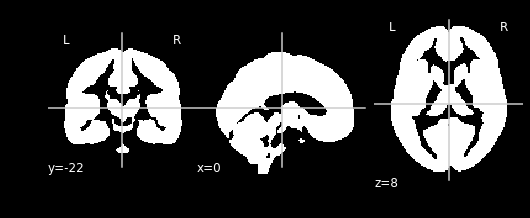

In [46]:
plotting.plot_anat('/imaging/mz01/fmriprep/GM_mask.nii', dim=-1)